# TOF Sensor Outdoor Tests

## Objective

This notebook aims to assess the TOF sensor's capability in accurately detecting and measuring distances of vehicles in real-world conditions.

## Experiment Details

### Experiment Setup

1. **Stationary Test**: The sensor was initially mounted on a stationary bike alongside a bustling road to gauge its proficiency in detecting passing vehicles.
2. **Dynamic Test**: Retaining the setup, the bike was ridden on various roads, collecting data from vehicles overtaking the cyclist. This step transitioned the evaluation from a controlled setting to a more dynamic environment, offering insights into real-world applicability.

### Data Extraction

Data from the sensor was published over to AWS IoT's message broker via MQTT. I then extracted the data in to text files. Each line of measurement contains the time, distance, and signal strength:

```text
10:45:37 1623 4
```

-1 values indicate null points where data wasn't captured reliably.

```text
10:45:38 -1 0
```

## Technical Insights

1. **Sensor Frequency**: As per WaveShare's documentation, the sensor operates at a frequency of 10Hz, translating to 10 measurements every second.
2. **Vehicle Assumptions**:
    - Average Speed: Cyclist at 25km/h and Car at 50km/h.
    - Average Length: Bicycle at 2m and Car at 4m.
  
    ![Equation](../assets/screenshots/Equation.png)

Given the above, the sensor is estimated to log 2-3 points on average for each passing car. The actual points may vary based on the relative velocities and sizes of the vehicles.

## Code Setup

### Imports

To maintain a clean and organized notebook, various functionalities have been distributed into separate Python modules:

- [`cleaner.py`](../src/data/cleaner.py) includes data cleaning functions.
- [`loader.py`](../src/data/loader.py) aids in extracting sensor data from text files.
- [`basic_graphs.py`](../src/graphing/outdoor_graphs.py) provides utilities for data visualization.

In [1]:
import pathlib
import sys

import matplotlib.pyplot as plt

sys.path.append("../src")

from data import cleaner, loader
from graphing import outdoor_graphs

### Data Preparation and Loading

I first load the data from both stationary and dynamic tests.

In [ ]:
STATIONARY_PATH = pathlib.Path("../data/processed/tof_outdoor_tests/stationary_test.txt")
LAKESIDE_RD_PATH = pathlib.Path("../data/processed/tof_outdoor_tests/lakeside_drive.txt")

## Stationary Test

In the initial test, the sensor was mounted on a stationary bike along Corporation Rd., an area with moderate traffic. A GoPro was also set up to record passing vehicles. By comparing the sensor's data with the GoPro footage, we assessed the sensor's reliability.

### Raw Data Analysis

- **Scatter Plot Observations**: The scatter plot below showcases all the distances the sensor measured. While there are clear clusters representing passing vehicles, the volume of spurious data is notably high.
- **Data Cleaning Objective**: The primary goal of data cleaning was to eliminate these irrelevant points without affecting the genuine clusters indicative of passing vehicles.

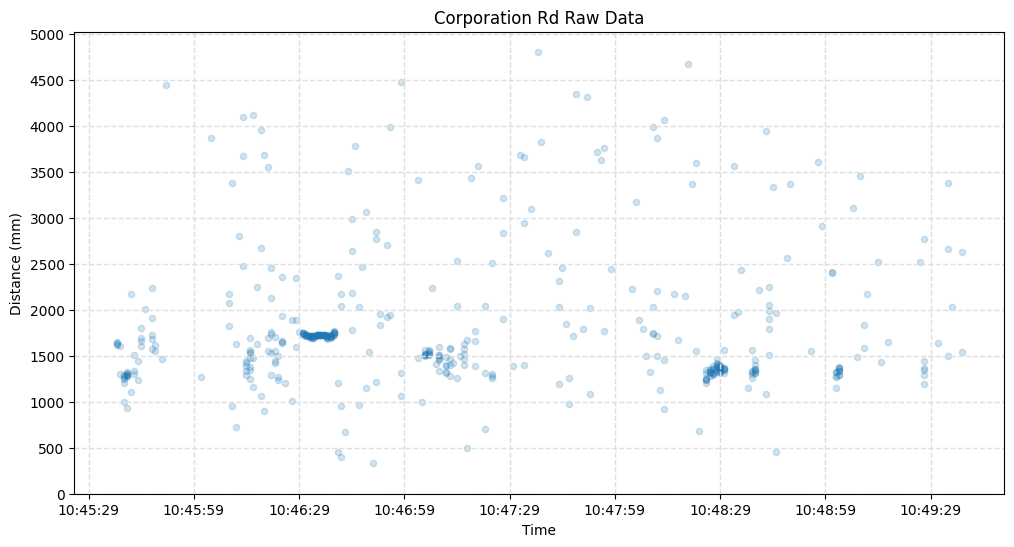

In [5]:
timing, distances, strengths = loader.load_data_from_file(STATIONARY_PATH, clean=False)
fig, axes = plt.subplots(figsize=(12, 6))
outdoor_graphs.scatter_time_vs_distance(axes, timing, distances, "Corporation Rd Raw Data")
plt.show()

### Data Cleaning Algorithm

- **Distance Constraint**: All points beyond a 2.5m distance were removed. Preliminary tests highlighted the sensor's unreliability in daylight beyond this distance. Additionally, for the project's objective, measurements beyond 2.5m were not crucial.
- **Cluster Identification**: Distances that weren't in proximity (within two points) of other distances were removed, ensuring a minimum cluster size of 2 points.
- **Graphical Representation**:
    - The first graph showcases the cleaned data, which now more prominently displays clusters representing vehicle passes.
    - The second graph traces the sensor's signal strength over time, showing pronounced spikes aligned with the clusters from the first graph. This correlation suggests the sensor's reliability during vehicle passes.

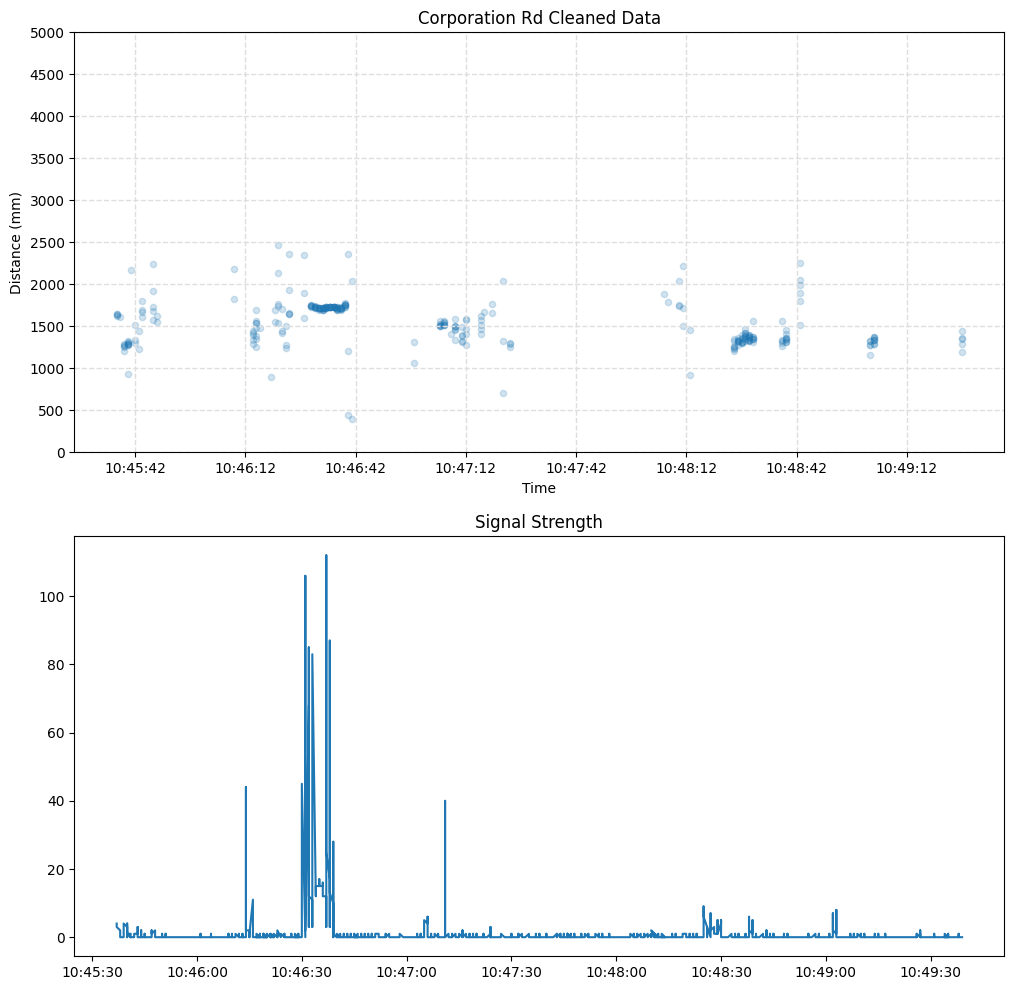

In [6]:
fig, axes = plt.subplots(2, figsize=(12, 12))

cleaned_distances = cleaner.clean_tof_data(distances)
outdoor_graphs.scatter_time_vs_distance(axes[0], timing, cleaned_distances, "Corporation Rd Cleaned Data")

axes[1].plot(timing, strengths)
axes[1].set_title("Signal Strength")

plt.show()

### Data Cross-Reference with Video Feed

- **General Observations**:
  1. The cleaned data effectively pinpointed the clusters representing passing vehicles.
  2. The initial set of points was recorded before the video started.
  3. A pronounced cluster at 10:46:30 corresponds to a car that halted adjacent to the sensor due to a red signal.
  4. At 10:47:10, the sensor captured a sequence of 8 vehicles.
- **Vehicle Type Analysis**:
  1. The following clusters primarily consisted of larger vehicles, such as buses and trucks. The sensor’s performance seemed enhanced with these due to their expansive surface area, affording more measurement time.
  2. However, the sensor couldn't distinguish between consecutive vehicles, often merging them into a single cluster.
- **Speed Consideration**: It's worth noting that vehicles on this particular road were relatively slow-moving. This behavior could impact the sensor's performance in different conditions, possibly making it less reliable for faster-moving vehicles.

![Corporation Road](../assets/annotated_graphs/Corporation_Rd.png)

## Cycling Tests

Now, it was time to test the sensor on the road in real-world conditions. I mounted the sensor with its casing on a bike and rode it down different roads in Singapore.

### Lakeside Road

- In this test, the sensor was attached to the bike and cycled down Lakeside Rd which was had very light traffic.
- The scatter plot below show the raw data. Even in this setting with little vehicles, the amount of spurious data was still overwheliming.

In [7]:
timing, distances, strengths = loader.load_data_from_file(LAKESIDE_RD_PATH, clean=False)

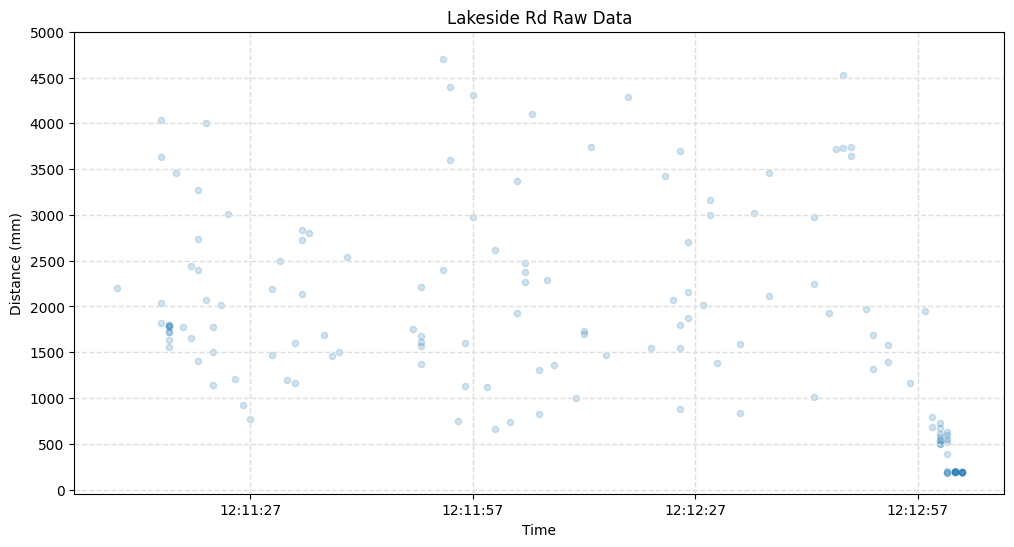

In [8]:
fig, axes = plt.subplots(figsize=(12, 6))
outdoor_graphs.scatter_time_vs_distance(axes, timing, distances, "Lakeside Rd Raw Data")
plt.show()

- I used the same cleaning algorithm to clean the raw data.
- Below is a scatter plot of the cleaned data, which again appears to correctly identify the clusters of points representing vehicle passes.
- The second graph shows signal strength, which appears to spike only at the biggest clusters. This also implies that the sensor is not very confident when smaller vehicles like cars pass it.

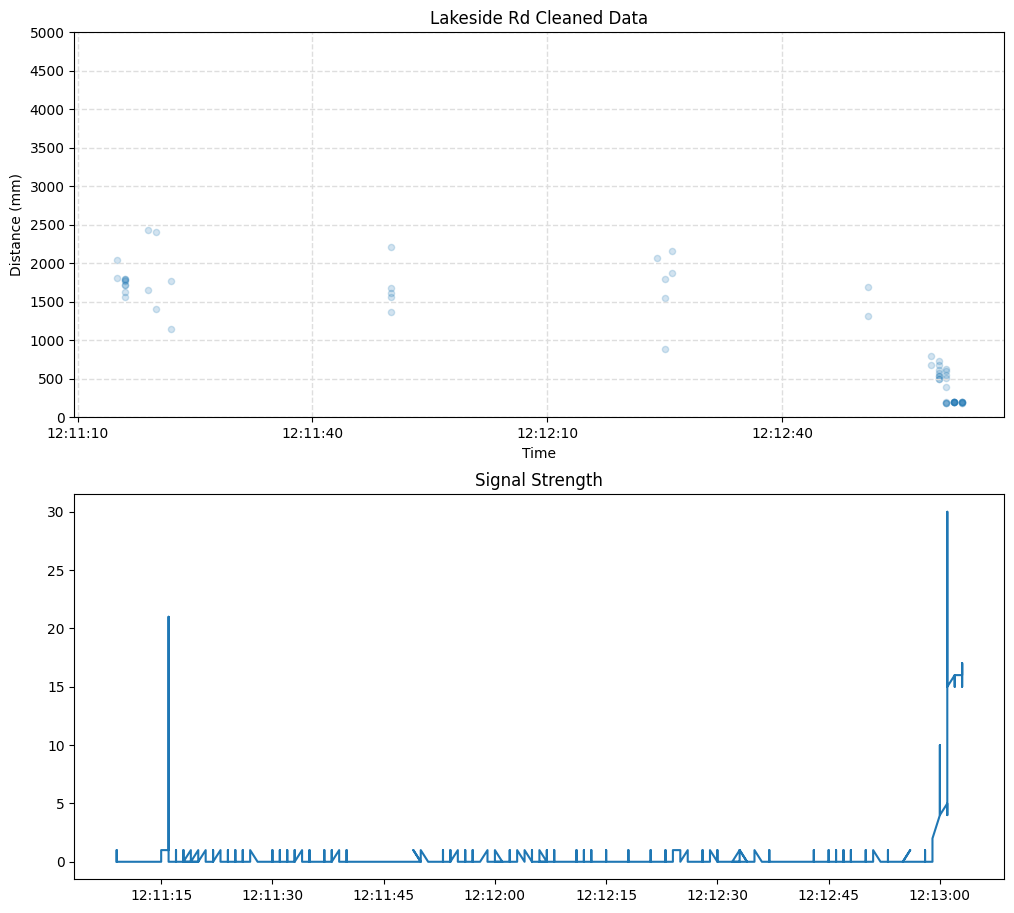

In [9]:
fig, axes = plt.subplots(2, figsize=(12, 11))

cleaned_distances = cleaner.clean_tof_data(distances)
outdoor_graphs.scatter_time_vs_distance(axes[0], timing, cleaned_distances, "Lakeside Rd Cleaned Data")

axes[1].plot(timing, strengths)
axes[1].set_title("Signal Strength")

plt.show()

- Next, I annotated the graph using the Gro Pro videofeed to show the points at which vehicles passed the bike.
- The first set of points was created before the video feed started and before the bike started moving.
- We can see that the sensor could detect 3 passing vehicles - a moving car, a moving truck, and a stationary struck near the end. The cluster of points formed at the stationary truck is very obvious as the truck was the closest to the bike and was also not moving.
- It can also be seen that the sensor failed to detect a moving motorbike, as it was too small.
- Around 12:12:46 there are two spurious data points that weren't cleaned.

![Lakeside Rd Annotated](../assets/annotated_graphs/Lakeside_Rd.png)

## Conclusion

In conclusion, these outdoor tests reveal the difficulty in using the TOF sensor for long-distance, reliable testing. First, the amount of spurious data generated by the sensor is overwhelming and while the cleaning algorithm introduced was somewhat effective, the data still contained leftover spurious points. Moreover, it was difficult to precisely say at what point could a cluster of measurements be considered of a vehicle pass. This was a result of the sensor's very performance in strong daylight. In addition, while testing, the sensor would very easily stop running if it was moved too suddenly from position. Overall, while the TOF is somewhat effective at measuring vehicle passes, I would opt for a sensor that is more robust and reliable.